In [8]:
import numpy as np
import pandas as pd
from scipy.stats import moment
from scipy.optimize import lsq_linear
import matplotlib.pyplot as plt

order_of_polynom: int = 6

def find_coax_sens(df_calib: pd.DataFrame) -> float:
    df: pd.DataFrame = df_calib[3:]
    zenith_coax_angle: float = find_zenith_coax(df)
    zen_coax: float = np.average(df.loc[df['zenith angle'] == zenith_coax_angle, 'zen sens'].to_numpy())
    azim_coax: float = np.average(df.loc[df['zenith angle'] == zenith_coax_angle, 'azim sens'].to_numpy())
    return zen_coax, azim_coax

def define_aprox_coefs(df_calib: pd.DataFrame) -> list:
    '''Находим коэффициенты апроксимирующего полинома шестой степени из калибровочных данных'''
    df: pd.DataFrame = df_calib
    radius: list = df['radius sens'].to_numpy()
    thetta: list = df['zenith angle'].to_numpy()
    A: list = np.vstack([radius**i for i in range(order_of_polynom + 1)]).T
    coefficients: list = lsq_linear(A, thetta).x
    return coefficients

def define_aprox_polynom(df_calib: pd.DataFrame) -> np.poly1d:
    '''Находим полином шестой степени по коэффициентам'''
    df: pd.DataFrame = df_calib
    calib_coefs: list = define_aprox_coefs(df)
    calib_polynomial: np.poly1d = np.poly1d(np.flip(calib_coefs))
    return calib_polynomial

def find_angle_error(df_calib: pd.DataFrame) -> np.ndarray:
    '''Находим отклонение теоретических данных от экспериментальных'''
    df: pd.DataFrame = df_calib
    calib_polynom: np.poly1d = define_aprox_polynom(df)
    theor_data: np.ndarray = df['radius sens'].to_numpy()
    exp_dat: np.ndarray = df['zenith angle'].to_numpy()
    deviation_buff: np.ndarray = calib_polynom(theor_data) - exp_dat
    return deviation_buff

def plot_teor_exp_calib(df: pd.DataFrame) -> None:
    '''График экспериментальных данных с апроксимирующим полиномом 6 порядка'''
    calib_df: pd.DataFrame = df
    x_min: float = np.min(calib_df['radius sens'].to_numpy())
    x_max: float = np.max(calib_df['radius sens'].to_numpy())
    x_new: np.ndarray = np.arange(x_min, x_max)
    y_new: np.ndarray = define_aprox_polynom(calib_df)(x_new)

    x: np.ndarray = calib_df['radius sens'].to_numpy()
    y: np.ndarray = calib_df['zenith angle'].to_numpy()

    fig, ax = plt.subplots()
    ax.set_title('Зенитный угол датчика')
    ax.set_xlabel('Расстояние от центра, пикс.')
    ax.set_ylabel('Зенитный угол, град.')
    plt.grid(True)
    plt.plot(x_new, y_new, '-', x, y, '.')

    plt.show()

def plotZenithDeviation(df: pd.DataFrame) -> None:
    '''График отклонения экспериментального угла от теоретического'''
    calib_df: pd.DataFrame = df
    y_new: np.ndarray = find_angle_error(calib_df)
    y: np.ndarray = calib_df['zenith angle'].to_numpy()

    fig, ax = plt.subplots()
    plt.scatter(y, y_new, marker='o', c = 'r', s=15)
    plt.title('Отклонение зенитного угла')
    plt.ylim((-0.8, 0.8))
    plt.xlabel('Зенитный угол, град.')
    plt.ylabel('Отклонение зенитного угла, град.')
    plt.xticks(np.arange(0, 30, step=3))
    plt.yticks(np.arange(-0.8, 0.8, step=0.1))
    plt.grid(True)
    plt.show()

def find_matrix_dispersion(df_calib: pd.DataFrame | str) -> pd.DataFrame:
    if isinstance(df_calib, pd.DataFrame):
        df: pd.DataFrame = df_calib
    elif isinstance(df_calib, str):
        df: pd.DataFrame = read_calib_from_csv(df_calib)
    else:
        raise Exception("Wrong DataFrame type")
    zenith_df: pd.Series = df.loc[:, ['zenith angle']].drop_duplicates(ignore_index=True)
    radius_col: pd.DataFrame = df.loc[:, ['radius sens']]
    radius_col = radius_col.to_numpy().flatten()
    amount_unique_cells: int = len(zenith_df)
    number_azim_steps: int = len(radius_col) // amount_unique_cells
    dispersion_list: list = []
    dispersion: float = 0.0
    for i in range(amount_unique_cells):
        dispersion: float = round(float(moment(radius_col[i*number_azim_steps:(i+1)*number_azim_steps], 2)), 4)
        dispersion_list.append(dispersion)
    dispersion_list = np.array(dispersion_list)
    dispersion_df: pd.DataFrame = pd.DataFrame({'radius dispersion' : dispersion_list})
    dispersion_df = zenith_df.join(dispersion_df)
    result_df: pd.DataFrame = df.merge(dispersion_df, left_on='zenith angle', right_on='zenith angle')
    return result_df

def find_zen_angle_dispersion(df_calib: pd.DataFrame | str) -> np.ndarray:
    if isinstance(df_calib, pd.DataFrame):
        df: pd.DataFrame = df_calib
    elif isinstance(df_calib, str):
        df: pd.DataFrame = read_calib_from_csv(df_calib)
    else:
        raise Exception("Wrong DataFrame type")
    dispersion_order: int = 2
    digits: int = 4
    rows_num: int = df.index.stop
    zenith_steps_num: int = len(df.loc[:, 'zenith angle'].drop_duplicates())
    zenith_angle_exp: np.ndarray = df.loc[:, 'zen sens'].to_numpy()
    zenith_angle_thoer: np.ndarray = df.loc[:, 'zenith angle'].to_numpy()
    number_azim_steps: int = rows_num // zenith_steps_num
    zenith_dispersion: list = []
    for i in range(zenith_steps_num):
        err: list = abs(abs(zenith_angle_exp[i*number_azim_steps:(i+1)*number_azim_steps])
                            - abs(zenith_angle_thoer[i*number_azim_steps:(i+1)*number_azim_steps]))
        dispersion: float = round(float(moment(err, dispersion_order)), digits)
        zenith_dispersion.append(np.repeat(dispersion, number_azim_steps))
    zenith_dispersion = np.array(zenith_dispersion).flatten()
    return np.array(zenith_dispersion)


def find_zenith_coax(df_calib: pd.DataFrame | str) -> float:
    '''Находим соосное расположение ротатора по вертикальной оси'''
    if isinstance(df_calib, pd.DataFrame):
        df: pd.DataFrame = df_calib
    elif isinstance(df_calib, str):
        df: pd.DataFrame = read_calib_from_csv(df_calib)
    else:
        raise Exception("Wrong DataFrame type")
    df: pd.DataFrame = find_matrix_dispersion(df)
    dispersion: np.ndarray = df['radius dispersion'].to_numpy()
    min_dev: float = np.min(dispersion)
    zenith_coax_angle: float = df.loc[df['radius dispersion'] == min_dev, 'zenith angle'].iloc[0]
    return zenith_coax_angle

def find_coax_x_y(df_calib: pd.DataFrame | str) -> float:
    '''Находим зенитный и азимутальный центр матрицы'''
    if isinstance(df_calib, pd.DataFrame):
        df: pd.DataFrame = df_calib
    elif isinstance(df_calib, str):
        df: pd.DataFrame = read_calib_from_csv(df_calib)
    else:
        raise Exception("Wrong DataFrame type")
    zenith_coax_angle: float = find_zenith_coax(df)
    x_coax: float = np.average(df.loc[df['zenith angle'] == zenith_coax_angle, 'x sens'].to_numpy())
    y_coax: float = np.average(df.loc[df['zenith angle'] == zenith_coax_angle, 'y sens'].to_numpy())
    return x_coax, y_coax

def read_calib_from_csv(file_path: str) -> pd.DataFrame:
    df: pd.DataFrame = pd.read_csv(file_path, sep='\t')
    return df

def get_coax_coords(df_calib: pd.DataFrame | str) -> dict:
    if isinstance(df_calib, pd.DataFrame):
        df: pd.DataFrame = df_calib
    elif isinstance(df_calib, str):
        df: pd.DataFrame = read_calib_from_csv(df_calib)
    else:
        raise Exception("Wrong DataFrame type")
    x, y = find_coax_x_y(df)
    center_coords_dict: dict = {
        'x coax' : x,
        'y coax' : y,
        'zenith coax' : find_zenith_coax(df)
    }
    return center_coords_dict

df = pd.read_csv(r'D:\python_projects\Calibrator\utils\Intensity_tables\01-12-2024_16-11-05_Intensity.csv', sep='\t')
def plot_exp_angle_dispersion(df_calib: pd.DataFrame | str) -> None:
    if isinstance(df_calib, pd.DataFrame):
        df: pd.DataFrame = df_calib
    elif isinstance(df_calib, str):
        df: pd.DataFrame = read_calib_from_csv(df_calib)
    else:
        raise Exception("Wrong DataFrame type")
    theor_zen_angle: np.ndarray = df['zenith angle'].to_numpy()
    plt.scatter(theor_zen_angle, np.sqrt(find_zen_angle_dispersion(df_calib)), s=15)
    plt.grid(True)
    plt.xlabel('Угол поворота, град.')
    plt.ylabel('Среднеквадратичное отклонение угла')
    plt.title('Среднеквадратичное отклонение угла датчика')
    plt.show()

# find_zenith_coax(df)
# define_aprox_coefs(df)
find_coax_sens(df)

(nan, nan)

In [109]:
df = pd.read_csv(r"D:\python_projects\Calibrator\utils\Intensity_tables\12-14-2023_17-31-16_Intensity.csv", sep='\t')
dispersion_order: int = 2
digits: int = 4
rows_num: int = df.index.stop
zenith_steps_num: int = len(df.loc[:, 'zenith angle'].drop_duplicates())
zenith_angle_exp: np.ndarray = df.loc[:, 'zen sens'].to_numpy()
zenith_angle_thoer: np.ndarray = df.loc[:, 'zenith angle'].to_numpy()
number_azim_steps: int = rows_num // zenith_steps_num
zenith_dispersion: list = []
for i in range(zenith_steps_num):
    err: list = abs(abs(zenith_angle_exp[i*number_azim_steps:(i+1)*number_azim_steps])
                        - abs(zenith_angle_thoer[i*number_azim_steps:(i+1)*number_azim_steps]))
    dispersion: float = round(float(moment(err, dispersion_order)), digits)
    zenith_dispersion.append(np.repeat(dispersion, number_azim_steps))

zenith_dispersion = np.array(zenith_dispersion).flatten()
zenith_dispersion

array([0.0001, 0.0001, 0.0001, 0.0001, 0.0002, 0.0002, 0.0002, 0.0002,
       0.    , 0.    , 0.    , 0.    , 0.0001, 0.0001, 0.0001, 0.0001,
       0.0002, 0.0002, 0.0002, 0.0002, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0004, 0.0004, 0.0004, 0.0004, 0.0007, 0.0007, 0.0007, 0.0007,
       0.0008, 0.0008, 0.0008, 0.0008, 0.0007, 0.0007, 0.0007, 0.0007])

In [110]:
zenith_angle_exp: np.ndarray = df.loc[:, 'zen sens'].to_numpy()
zenith_angle_thoer: np.ndarray = df.loc[:, 'zenith angle'].to_numpy()
number_azim_steps: int = rows_num // zenith_steps_num
number_azim_steps

4

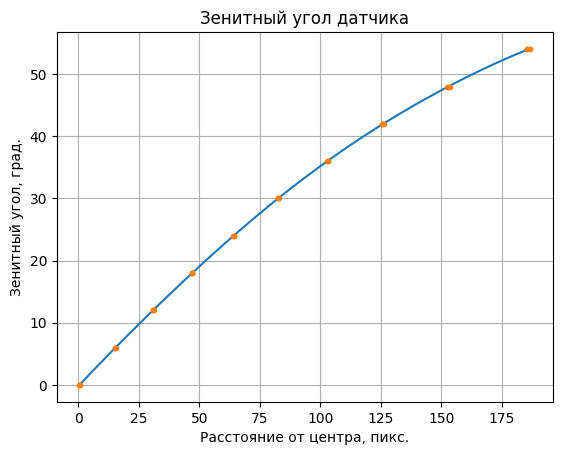

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# df = pd.read_csv(r"D:\python_projects\Calibrator\utils\Intensity_tables\12-14-2023_17-31-16_Intensity.csv", sep='\t')
# exp_zen_angle = df['zen sens'].to_numpy()
# theor_zen_angle = df['zenith angle'].to_numpy()

# fig = plt.figure()

# axes = fig.subplots()
# axes.scatter(theor_zen_angle, abs(exp_zen_angle), c='g', s=20)
# axes.scatter(theor_zen_angle, abs(theor_zen_angle), c='r', s=20)
# axes.set_title('Зенитный угол датчика')
# axes.grid(True)
# axes.legend(['Датчик', 'Ротатор'])
# axes.set_xlabel('Угол поворта, град.')
# axes.set_ylabel('Угол датчика и поворота, град.')

# plt.show()
plot_teor_exp_calib(df)

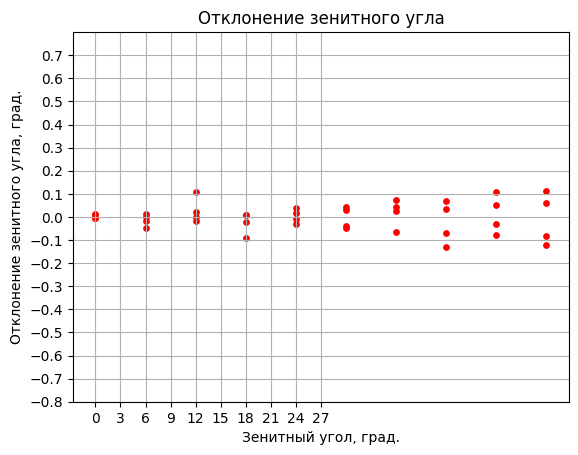

In [5]:
plotZenithDeviation(df)

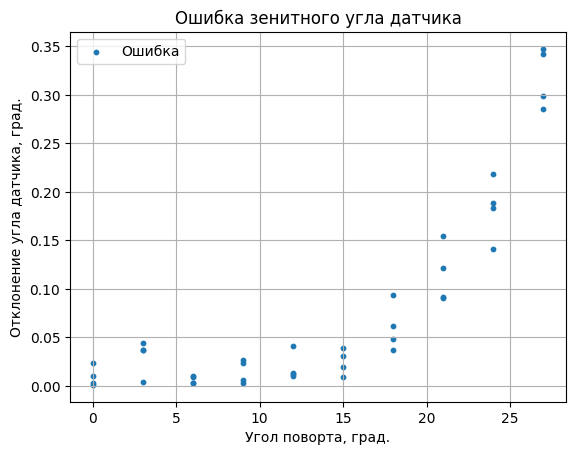

In [113]:
fig = plt.figure()

axes = fig.subplots()

axes.scatter(theor_zen_angle, abs(abs(exp_zen_angle) - abs(theor_zen_angle)), s=10)
axes.set_title('Ошибка зенитного угла датчика')
axes.grid(True)
axes.legend(['Ошибка'])
axes.set_xlabel('Угол поворта, град.')
axes.set_ylabel('Отклонение угла датчика, град.')
plt.show()

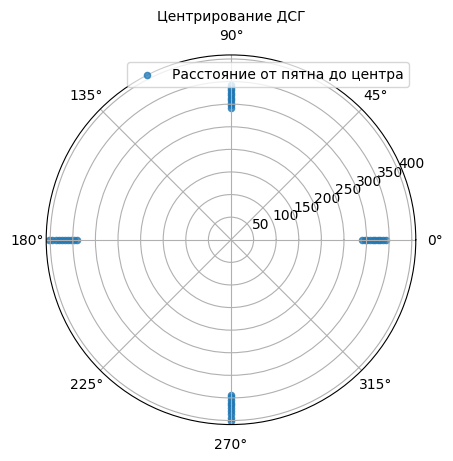

In [114]:
x: np.ndarray = df['x sens'].to_numpy() - 235.248
y: np.ndarray = df['y sens'].to_numpy() - 248.456
azim: np.ndarray = df['azimuth angle'].to_numpy()
fig = plt.figure()
ax = fig.add_subplot(projection='polar')
ax.scatter(azim/180 * np.pi, np.sqrt(x**2 + y**2), alpha=0.75, s=20, label='Расстояние от пятна до центра')
ax.set_title('Центрирование ДСГ', {'fontsize' : 10})
ax.legend(loc='best')
plt.show()

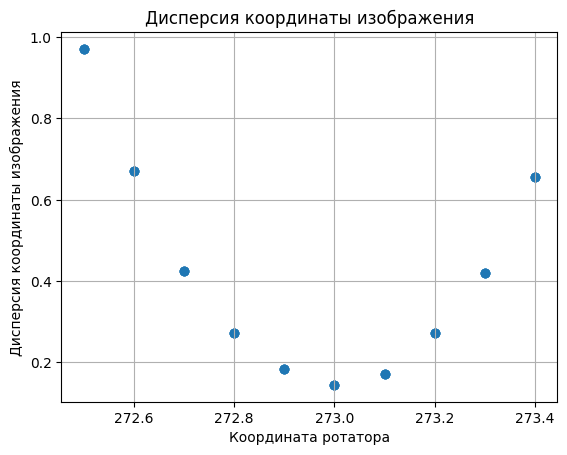

In [2]:
# df = read_calib_from_csv(r'D:\python_projects\Calibrator\utils\Normal_fall\12-13-2023_18-04-06_Intensity.csv')
extended_df = find_matrix_dispersion(df)
disp = extended_df['radius dispersion'].to_numpy()
zenith_angle = extended_df['zenith angle'].to_numpy()
plt.scatter(zenith_angle, disp)
plt.grid(True)
plt.title('Дисперсия координаты изображения')
plt.xlabel('Координата ротатора')
plt.ylabel('Дисперсия координаты изображения')
plt.show()

In [11]:
df

,sensor angle,rotator angle,"time, sec"
0,51.5692,221.519885,1.705054e+09
1,42.9032,230.092737,1.705054e+09
2,34.3258,238.667456,1.705054e+09
3,25.7442,247.242603,1.705054e+09
4,17.1979,255.804883,1.705054e+09
5,8.6650,264.372485,1.705054e+09
6,0.6688,272.959949,1.705054e+09
7,8.5847,281.532288,1.705054e+09
8,17.1785,290.109717,1.705054e+09
9,25.6557,298.689917,1.705054e+09


In [27]:
df = read_calib_from_csv(r'D:\python_projects\Calibrator\utils\Angle_logs\01-12-2024_17-02-59_Velocity.csv')
time = df['time, sec'].to_numpy()
sensor_angle = df['sensor angle'].to_numpy()
rotator_anlge = df['rotator angle'].to_numpy()
sensor_angle[0:6] = -sensor_angle[0:6]
(sensor_angle[13] - sensor_angle[0]) / (time[13] - time[0]), (rotator_anlge[13] - rotator_anlge[0]) / (time[13] - time[0])

(4.895000409938665, 5.000061703607736)

In [33]:
for i in range(2, len(rotator_anlge) - 3):
    print(abs(sensor_angle[i] - sensor_angle[i-1]) / (time[i] - time[i-1]),
           (rotator_anlge[i] - rotator_anlge[i-1]) / (time[i] - time[i-1]),
           abs(sensor_angle[i + 1] - sensor_angle[i-1]) / (2*(time[i] - time[i-1])),
           abs(sensor_angle[i - 2] - 8*sensor_angle[i-1] + 8*sensor_angle[i+1] - sensor_angle[i+2]) / (12*(time[i] - time[i-1])))

5.000573101042195 4.999010232930544 5.001797388531667 4.999207923325761
5.005060037127216 5.001296143080197 4.994765999924911 4.995621406226896
4.989383996069266 4.998713380778671 4.9854724936912005 4.944790922938232
4.980137185909511 5.000390957221803 5.213855609434626 5.282165745082236
5.435534337834343 5.000905533752584 5.022677616155321 5.028646699161471
4.614860321214057 4.997555110370863 4.812463487736563 4.749243494474102
5.02172663691944 5.012160474528994 4.987659441623714 5.015191734677179
4.958214185592461 5.018457783657534 4.991114146421459 4.989466711345873
4.969213703338553 4.969466348808937 4.945263455097263 4.945586455627088
4.960435229749718 4.999995356611558 4.991281604299056 5.104530754463969
